# Extract abstract and corpus
Defined variables:
* site: url link to site

Output variables:
* original_abstract: abstract sentence list
* original_corpus: corpus sentence list
* clean_abstract: remove stopwords, lowercased, punctuation, etc. cleaned sentence list of abstract
* clean_corpus: cleaned corpus, list of sentences

Note: original and cleaned versions should have same length, for consistency.
Note each sentence is itself list of words.

NOTE: run sci-spacy and pip installs first, which require runtime restarting, and may override glove etc. imports

In [0]:
import numpy as np
import pandas as pd
import re

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def read_file(filename):
  """
  Obtains original text in filename, in sentence list form.
  """
  reader = open(filename)
  text = ''
  for line in reader:
    text += line + '\n'

  #obtain a sentence list of the original text (abstract or corpus)
  original_text = text.strip().split('.')
  return original_text

In [0]:
def clean_text(original_text, sentence_length_cutoff=5):
  """
  obtain a clean sentence list of original_text
  no punctuation, lowercase, no stop words, and no short sentences
  """
  clean_text = []
  for sentence in original_text:
    sentence = sentence.lower()
    sentence = re.sub("[^a-zA-Z0-9.]", " ", sentence)
    sentence = sentence.split()
    sentence_no_stopwords = [word for word in sentence if word not in stop_words]
    if len(sentence_no_stopwords) < sentence_length_cutoff:
      sentence_no_stopwords = [] #treat it as an empty sentence.
      #we still need something there for a placeholder, for indexing.
    clean_text.append(sentence_no_stopwords)
  return clean_text


In [0]:
#note the length is the same between original versus cleaned.
original_abstract = read_file('abstract_4.txt')
clean_abstract = clean_text(original_abstract)

In [0]:
original_corpus = read_file('corpus_4.txt')
clean_corpus = clean_text(original_corpus)

# Apply GloVe to a corpus
Defined variables:
* clean_corpus

Output variables:
* glove_summary, a list of (score, original sentence, clean sentence, index) sorted highest to lowest score

Note: we can use index to find corresponding clean_corpus sentences if desired.

In [7]:
# download GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-04-29 13:49:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-29 13:49:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-29 13:49:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
# store a dictionary of word to corresponding GloVe vector
word_to_vec = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_to_vec[word] = coefs
f.close()

## Vectorize corpus
Output
* vec_corpus, list of vectors. 1 vector for each sentence.

In [0]:
def vectorize_word(w):
  """
  Returns the 100-dimension GloVe vector for a word, or zero vector if not found.
  """
  return word_to_vec.get(w, np.zeros((100,)))

In [0]:
def vectorize_summary(clean_sentence_list):
  """
  Returns a list of vectors, where each vector represents the vector of a sentence.
  The vector of each sentence is the mean of the vectors of the words in the sentence.
  """
  vec_sentences = []
  for sentence in clean_sentence_list:
    vec_sentences.append(np.mean(
        np.array([vectorize_word(w) for w in sentence])
        , axis=0))
  return vec_sentences

In [11]:
vec_glove_corpus = vectorize_summary(clean_corpus)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Obtain Similarity Matrix
Input
* vec_glove_corpus or vec_cui_corpus

Output
* matrix_glove_corpus or matrix_cui_corpus: similarity matrix of vec_glove_corpus

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
def get_sim_matrix(vec_sentences, vec_length):
  """
  vec_length is 100 for gloVe, and 500 for Cui2vec
  """
  similarity_matrix = np.zeros(
      [len(vec_sentences), len(vec_sentences)], dtype=float)
  #two perpendicular vectors have 0 similarity, because cosine of 90 is 0.

  for i in range(len(vec_sentences)):
    for j in range(len(vec_sentences)):
      if i != j:
          if np.isnan(np.sum(vec_sentences[i])) or np.isnan(np.sum(vec_sentences[j])):
            similarity_matrix[i][j] = 0
            #one of them is nan
          else:
            similarity_matrix[i][j] = cosine_similarity(
                vec_sentences[i].reshape(1,vec_length), # because 100 dimension GloVe vector
                vec_sentences[j].reshape(1,vec_length))[0,0]
  return similarity_matrix

In [0]:
matrix_glove_corpus = get_sim_matrix(vec_glove_corpus, 100)

# Perform TextRank
Input:
* matrix_glove_corpus, or matrix_cui_corpus
* original_corpus
* clean_corpus

Output:
* glove_summary, or cui_summary

In [0]:
import networkx as nx

In [0]:
def textrank(sim_matrix, original_text, clean_text, top_n=5):
  """
  Get the top_n sentences via textrank on the sim_matrix
  select corresponding text from original_text (uncleaned sentence list)
  """
  graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank(graph) #each of the sentences, and corresponding score

  ranked_sentences = sorted((
      (scores[i],orig_sentence, clean_text[i], i) for i,orig_sentence in enumerate(original_text)), 
      reverse=True)
  print("Summary:")
  for i in range(top_n):
    print (ranked_sentences[i][1].strip()) #just print the sentence for viewing
    #some original sentences still had \n attached, so strip
  return ranked_sentences


In [0]:
top_n = 5#len(original_abstract) #or 5

In [18]:
glove_summary = textrank(matrix_glove_corpus, original_corpus, clean_corpus, top_n=top_n)

Summary:
Total phenolic and flavonoid content and antioxidant activities during germination of soybeans of different sizes under light and dark conditions



At the seed stage, the total content of phenolic compounds (TPC) was found to be slightly higher in small-seeded soybeans (13
In addition, the isoflavone content of soybeans can be elevated in response to various stress factors; for instance, heat treatment at 60°C for 1 h has been shown to increase isoflavone content compared with the control [11]
In particular, in the Dawonkong, Socheongja, and Youngwoljwinuni B/Y cultivars, we found that compared with early germination, glucoside content increased by more than 33-fold after 7 days of germination
Changes in the total phenolic content and total flavonoid content of small-seeded (A–E) and large-seeded (F–J) soybeans during germination under light and dark conditions
Changes in the total phenolic content, total flavonoid content, and antioxidant activities of small-seeded (A–E) and

# Apply Cui2Vec to a Corpus

Defined variables:
* clean_corpus

Output variables:
* cui_summary

## Install scispacy

In [0]:
#!pip install scispacy

In [20]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz

     |████████████████████████████████| 17.0MB 1.2MB/s 
  Created wheel for en-core-sci-sm: filename=en_core_sci_sm-0.2.4-cp36-none-any.whl size=17161110 sha256=af97a07e597b77fed59ab4a1a0bdf03a10a4fa40708d47a63f7bb8e4f595d7ac
  Stored in directory: /root/.cache/pip/wheels/34/60/b9/fabd9c3eeba17ed66df745479f2fc502a6702755cb4a9632f2
Successfully built en-core-sci-sm


In [21]:
!pip install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.4)


In [0]:
import spacy
import scispacy
import en_core_sci_sm   #The model we are going to use
from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker

In [23]:
nlp_reader = en_core_sci_sm.load()
cui_linker = UmlsEntityLinker(resolve_abbreviations=True)
nlp_reader.add_pipe(cui_linker) # Each entity is linked to UMLS with a score# (currently just char-3gram matching).

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmppjfsc9eo
Finished download, copying /tmp/tmppjfsc9eo to cache at /root/.scispacy/datasets/ea855fd121a193f03190a91417c209d4cd97e63d3ce4b456c248ef7c13a4ca77.03518aabd12de2103a27a50302f37c3d87b0f313a8be08b5ec306c9c4334b9b1.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/nmslib_index.bin not found in cache, downloading to /tmp/tmp23wiyknd
Finished download, copying /tmp/tmp23wiyknd to cache at /root/.scispacy/datasets/5f620d1bd549a98c005ed601a73806ea2cd1a86ae6c54bbc62bcb3b452ca2630.27a7ac6807fde6628311ff7d70b86fefc640d0eb70637b544c591722a2c16c2a.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpb8n37ehm
Finished download, copying /tmp/tmpb8n37ehm to cache at /root/.scispacy/datasets/ffb7a77cdcb3c9233c1e400

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/concept_aliases.json not found in cache, downloading to /tmp/tmpv2nvemq8
Finished download, copying /tmp/tmpv2nvemq8 to cache at /root/.scispacy/datasets/0f064d20aefab965d5772b2100f8436b3541e7d5313c76cfe5fe070902f149fe.31df9cdb04729860a81bd6c980224ed2bff582586c398d0c9b96ae4e257b9da2.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_2017_aa_cat0129.json not found in cache, downloading to /tmp/tmpbv5fyofe
Finished download, copying /tmp/tmpbv5fyofe to cache at /root/.scispacy/datasets/13b30cd31cd37c1b52f3df6ea023061172d16e9941660e677fdbb29489af7410.4ad71d86ce780e00cab131c7e3b81acfd2f11dd80ccd61125c8bcde506f2ab8a.umls_2017_aa_cat0129.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmp7ap74yt8
Finished download, copying /tmp/tmp7ap74yt8 to cache at /root/.scispacy/datasets/21a1012c532c3a431d60895c509f5b4d45b0f

## Load cui2vec

In [24]:
!wget https://ndownloader.figshare.com/files/10959626?private_link=00d69861786cd0156d81 -O cui2vec_pretrained.csv.zip

--2020-04-29 13:59:10--  https://ndownloader.figshare.com/files/10959626?private_link=00d69861786cd0156d81
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 18.200.62.117, 34.249.140.248, 52.17.144.100, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|18.200.62.117|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10959626/cui2vec_pretrained.csv.zip [following]
--2020-04-29 13:59:12--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10959626/cui2vec_pretrained.csv.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.97.162
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.97.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 482307559 (460M) [binary/octet-stream]
Saving to: ‘cui2vec_pretrained.csv.zip’

cui2vec_pretrained. 100%[===================>] 459.96M  11.8MB/s    in 41s     

20

In [25]:
!unzip cui2vec_pretrained.csv.zip #or try taking out the .zip

Archive:  cui2vec_pretrained.csv.zip
  inflating: cui2vec_pretrained.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._cui2vec_pretrained.csv  


In [0]:
import numpy as np
import pandas as pd
embeddings = pd.read_csv("cui2vec_pretrained.csv")

In [0]:
def word_list_to_sent_list(clean_text):
  """
  converts to format where each entry of list is a sentence
  """
  output = []
  for sentence in clean_text:
    if len(sentence) == 0:
      output.append('')
    else:
      output.append(' '.join(sentence))
  return output

## Find entities in each sentence

In [0]:
def clean_sent_list_to_ent_list(clean_sentence_list):
  """
  Takes clean sentence list, such as ['sentence is here', 'sentence is here'].
  Note this isn't quite the same as clean_corpus, where each sentence is further a list of words.
  """
  sent_list = []
  for s in clean_sentence_list:
    sent_list.append(list(nlp_reader(s).ents)) #might be blank.
  return sent_list

## Entity to vector

In [0]:
def ent_to_vec(entity, cap = 3):
  vecsum = np.zeros((500,))
  maxrange = min(cap, len(entity._.umls_ents))
  for i in range(maxrange):
    cuii, scorei = entity._.umls_ents[i]
    v = cui_to_vec(cuii)
    vecsum += scorei*v
  if maxrange > 0:
    return vecsum/maxrange 
  return np.zeros((500,)) # if maxrange is 0, then just return
  #return np.mean(vecs, axis=0)

## Convert a cui to vector representation

In [0]:
def cui_to_vec(cui):
  cui = str(cui).upper()
  s = embeddings.loc[embeddings['Unnamed: 0'] == cui] #make sure to run embeddings = pd.read_csv...
  vec = s.drop("Unnamed: 0", axis=1)
  if s.shape[0] == 0: #if not available cui, then return 0 (i.e. 0 rows)
    return np.zeros((500,))
  return np.array(vec).ravel()

## Convert sentence list to vector list

In [0]:
def entList_to_vec(ent_list):
 # if len(ent_list) == 0:
  #  return np.zeros()
  outputsum = np.zeros((500,))
  nonzero_count = 0
  for ent in ent_list:
    v = ent_to_vec(ent)
    if np.sum(v) == 0:
      continue
    nonzero_count += 1
    outputsum += v
  if nonzero_count == 0:
    return np.zeros((500,))
  return outputsum/nonzero_count

In [0]:
def sentList_to_vecList(sent_list):
  vec_list = []
  for ent_list in sent_list:
    vec_list.append(entList_to_vec(ent_list))
  return vec_list

In [0]:
entity_list_list = clean_sent_list_to_ent_list(word_list_to_sent_list(clean_corpus))

In [0]:
vec_cui_corpus = sentList_to_vecList(entity_list_list)

## Similarity Matrix

In [0]:
matrix_cui_corpus = get_sim_matrix(vec_cui_corpus, 500)

## Perform TextRank

In [0]:
top_n = 5#len(original_abstract) # can use 5

In [37]:
cui_summary = textrank(matrix_cui_corpus, original_corpus, clean_corpus, top_n=top_n)

Summary:
In addition, the isoflavone content of soybeans can be elevated in response to various stress factors; for instance, heat treatment at 60°C for 1 h has been shown to increase isoflavone content compared with the control [11]
Changes in total isoflavones of small-seeded (A–E) and large-seeded (F–J) soybeans during germination under light and dark conditions
Total phenolic and flavonoid content and antioxidant activities during germination of soybeans of different sizes under light and dark conditions



At the seed stage, the total content of phenolic compounds (TPC) was found to be slightly higher in small-seeded soybeans (13
As in the case of total isoflavones, the total phenolic content did not vary according to the seed coat and cotyledon color
With respect to aglycones, we observed an apparent increase in the content of these isoflavones in large-seeded soybeans, and after 7 days of germination, Cheongja3 contained higher amounts of aglycones (110 μg/g DW) than of glucosid

# Evaluate summary against abstract
Defined variables:
* original_abstract
* clean_abstract
* glove_summary
* cui_summary

Output variables:

ROUGE n-gram implementation

## Direct comparison by eye

In [0]:
top_n = 5#len(original_abstract)

In [0]:
def direct_comparison(summary, abstract, top_n=5):
  summary_string = ''
  for _,_,_,i in summary[0:top_n]:
    summary_string += original_corpus[i].strip() + '. '
  abstract_string = '. '.join(abstract)
  return summary_string, abstract_string

In [0]:
s_cui,a = direct_comparison(cui_summary, original_abstract, top_n=top_n)

In [41]:
print(s_cui) #print generated summary

In addition, the isoflavone content of soybeans can be elevated in response to various stress factors; for instance, heat treatment at 60°C for 1 h has been shown to increase isoflavone content compared with the control [11]. Changes in total isoflavones of small-seeded (A–E) and large-seeded (F–J) soybeans during germination under light and dark conditions. Total phenolic and flavonoid content and antioxidant activities during germination of soybeans of different sizes under light and dark conditions



At the seed stage, the total content of phenolic compounds (TPC) was found to be slightly higher in small-seeded soybeans (13. As in the case of total isoflavones, the total phenolic content did not vary according to the seed coat and cotyledon color. With respect to aglycones, we observed an apparent increase in the content of these isoflavones in large-seeded soybeans, and after 7 days of germination, Cheongja3 contained higher amounts of aglycones (110 μg/g DW) than of glucosides (8

In [42]:
print(a) #print abstract

In this study, we investigated changes in the isoflavone content, total phenolic content (TPC), total flavonoid content (TFC), antioxidant activities (DPPH, ABTS), and anti-inflammatory activities of small-seeded and large-seeded soybean cultivars during germination (light/dark conditions).  Total isoflavone content was higher at the seed stage in large-seeded soybeans, while it increased after 7 days of germination in small-seeded soybeans, particularly in response to light conditions, under which they had high TPC, TFC, and antioxidant activities.  In large-seeded soybeans, the germination environment did not significantly affect TFC or DPPH inhibition, whereas TPC and ABTS inhibition were high under dark germination conditions.  Extracts of sprouts exhibited superior anti-inflammatory activities.  Nitric oxide production was slightly lower in small-seeded and large-seeded soybeans germinated under light and dark conditions, respectively.  Our findings indicate that germinated soybea

In [0]:
s_glove,a = direct_comparison(glove_summary, original_abstract)

In [44]:
print(s_glove)

Total phenolic and flavonoid content and antioxidant activities during germination of soybeans of different sizes under light and dark conditions



At the seed stage, the total content of phenolic compounds (TPC) was found to be slightly higher in small-seeded soybeans (13. In addition, the isoflavone content of soybeans can be elevated in response to various stress factors; for instance, heat treatment at 60°C for 1 h has been shown to increase isoflavone content compared with the control [11]. In particular, in the Dawonkong, Socheongja, and Youngwoljwinuni B/Y cultivars, we found that compared with early germination, glucoside content increased by more than 33-fold after 7 days of germination. Changes in the total phenolic content and total flavonoid content of small-seeded (A–E) and large-seeded (F–J) soybeans during germination under light and dark conditions. Changes in the total phenolic content, total flavonoid content, and antioxidant activities of small-seeded (A–E) and larg

## Rouge

In [45]:
!pip install easy-rouge

In [0]:
from rouge.rouge import rouge_n_summary_level

In [0]:
def clean_summary_only(summary, top_n=5):
  """
  Extract only the clean summary sentences
  summary: [ (score, orig sentence, clean sentence, index), ...]
  """
  top_n = min(top_n, len(summary))
  return [summary[i][2] for i in range(top_n)]

In [0]:
def flatten_sentence_list(sentence_list):
  """
  joins all the words in sentence list into a single string
  """
  output = ''
  for sentence in sentence_list:
    output += ' '.join(sentence) + '. '
  return output

In [0]:
def rouge(summary, abstract):
  # make sure theyre flattened to a single string
  flat_summary = flatten_sentence_list(summary)
  flat_abstract = flatten_sentence_list(abstract)
  recall, precision, fscore = rouge_n_summary_level(flat_summary, flat_abstract, 1)
  print('ROUGE-1-R', recall)
  print('ROUGE-1-P', precision)
  print('ROUGE-1-F', fscore)

In [0]:
# get the summary words only
clean_cui_summary = clean_summary_only(cui_summary)
clean_glove_summary = clean_summary_only(glove_summary)

In [51]:
# apply rouge to compare
rouge(clean_cui_summary, clean_abstract)

ROUGE-1-R 0.7726315789473684
ROUGE-1-P 0.963254593175853
ROUGE-1-F 0.8574766355140188


In [52]:
rouge(clean_glove_summary, clean_abstract)

ROUGE-1-R 0.8221052631578948
ROUGE-1-P 0.9630086313193588
ROUGE-1-F 0.8869960249858035


## Histogram of scores

In [0]:
import matplotlib.pyplot as plt

In [0]:
# how many are zeros (e.g. in matrix also)

In [0]:
def scores(summary):
  return [summary[i][0] for i in range(len(summary))]

In [0]:
cui_scores = scores(cui_summary)
glove_scores = scores(glove_summary)

(array([ 65.,   2.,   0.,   0.,   2.,   5.,  16.,  25.,  70., 102.]),
 array([0.00064739, 0.00107641, 0.00150543, 0.00193445, 0.00236347,
        0.00279249, 0.00322151, 0.00365052, 0.00407954, 0.00450856,
        0.00493758]),
 <a list of 10 Patch objects>)

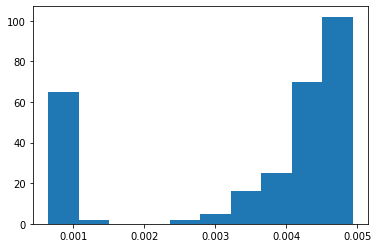

In [57]:
plt.hist(glove_scores)

(array([86.,  1.,  5.,  9., 25., 17.,  8., 20., 56., 60.]),
 array([0.00069867, 0.00123105, 0.00176343, 0.00229582, 0.0028282 ,
        0.00336058, 0.00389297, 0.00442535, 0.00495773, 0.00549012,
        0.0060225 ]),
 <a list of 10 Patch objects>)

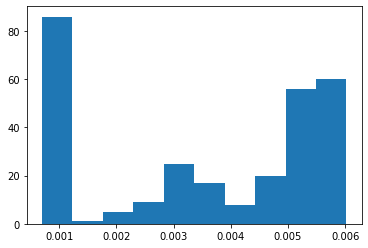

In [58]:
plt.hist(cui_scores)

## Matrix visualization
Input:
* matrix_text (matrix_glove_corpus, matrix_cui_corpus)

In [0]:
import matplotlib.pyplot as plt

In [0]:
def visualize_matrix(matrix_text, remove_blank_sentences=True):
  """
  Plots similarity matrix of sentence vectors.
  Option to remove blank sentences with 0 similarity.
  """
  if not remove_blank_sentences:
    plt.matshow(matrix_text, cmap=plt.cm.Blues)
    plt.show()
    return

  # remove all the zero'd sentences
  no_zero_mat = matrix_text[~np.all(matrix_text == 0, axis=1)]
  no_zero_mat = no_zero_mat[:,~np.all(no_zero_mat == 0, axis=0)]
  plt.matshow(no_zero_mat, cmap=plt.cm.Blues)
  plt.show()

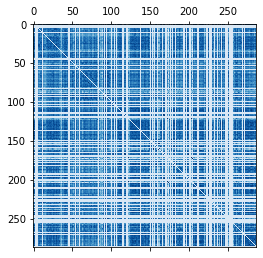

In [61]:
visualize_matrix(matrix_glove_corpus, remove_blank_sentences=False)

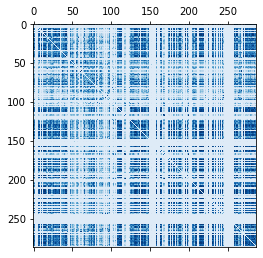

In [62]:
visualize_matrix(matrix_cui_corpus, remove_blank_sentences=False)

# Additional notes
* why sentence importance and length are correlated

In [0]:
def plot_length_vs_importance(summary):
  y = [(stc[0], len(stc[1])) for stc in summary]
  plt.scatter(*zip(*y))
  plt.xlabel("Importance Score")
  plt.ylabel("Sentence Length (chars)")
  plt.show()

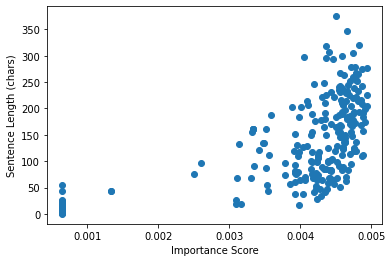

In [64]:
plot_length_vs_importance(glove_summary)

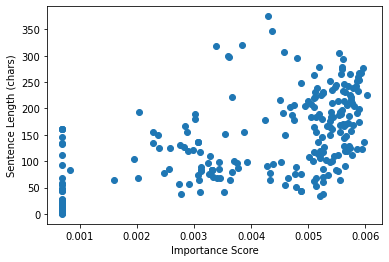

In [65]:
plot_length_vs_importance(cui_summary)